## Creating Directories to store python scripts and model
We will first create 2 empty folders - `Sripts` (this will contain all the python modules for the trainig, validation & testing the model etc.) and `Models` (which will contain model checkpoint)

Note that we are running this notebook from this stage in kaggle kernel. To build/Replicate the model, follow the exact same steps mentioned in the notebook. 

We first build our model in kaggle kernel because of the free computational resources, one can use google colab (free version) but it has certain limitations like it cannot handle the image size like we'll be using in this project. 

So we'll utilize the `kaggle computation resources` to carry out this project. 

In [2]:
import os
from pathlib import Path

## Creating Empty folders
scripts_file_path = Path("Scripts")
models_file_path = Path('Models')
scripts_file_path.mkdir(parents=True, exist_ok=True)
models_file_path.mkdir(parents=True, exist_ok=True)

## Creating Python modules in Scripts for training and prediction
First we will write/create python modules like for `augmentations`, `config`, `training & validation loops`, `prediction_to_generate_on_test_dataset` etc.

For training augmentations we'll be using like flipping the image, creating random patches in the image, randomly rotating 90 degrees, Adjusting the brightness and contrast, adding noise in the images, Shifting and sheering the image and finally normalizing the statistics of the image (since we will be using transfer learning therefore we need to prepare the images in the same way they were trained on - depending on the specific model we want to use).

In [3]:
%%writefile Scripts/augmentations.py
from Scripts.config import Config
import albumentations as A

training_augmentations = A.Compose(
    [
        A.CoarseDropout(p=0.6),
        A.RandomRotate90(p=0.6),
        A.Flip(p=0.4),
        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3),
                A.HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=60, val_shift_limit=50
                ),
            ],
            p=0.7,
        ),
        A.OneOf([A.GaussianBlur(), A.GaussNoise()], p=0.65),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.35, rotate_limit=45, p=0.5
        ),
        A.OneOf(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),
                A.PiecewiseAffine(p=0.3),
            ],
            p=0.7,
        ),
        A.Normalize(
            mean=Config.MEAN, std=Config.STD, max_pixel_value=255.0, always_apply=True
        ),
    ]
)

validation_augmentations = A.Compose(
    [
        A.Normalize(
            mean=Config.MEAN, std=Config.STD, max_pixel_value=255.0, always_apply=True
        )
    ]
)
testing_augmentations = A.Compose(
    [
        A.Normalize(
            mean=Config.MEAN, std=Config.STD, max_pixel_value=255.0, always_apply=True
        )
    ]
)

Writing Scripts/augmentations.py


Creating a config module which will contain model configurations like number of epochs to run, size of an image, weight decay (for regularization) etc., it also contains the path of the files and folders of the data.    

In [4]:
%%writefile Scripts/config.py
import torch

class Config:
    EPOCHS = 5
    IMG_SIZE = 512
    ES_PATIENCE = 2
    WEIGHT_DECAY = 0.001
    VAL_BATCH_SIZE = 32 * 2
    RANDOM_STATE = 1994
    LEARNING_RATE = 5e-5
    TRAIN_BATCH_SIZE = 32
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_COLS = [
        "image_name",
        "patient_id",
        "sex",
        "age_approx",
        "anatom_site_general_challenge",
        "target",
        "tfrecord",
    ]
    TEST_COLS = [
        "image_name",
        "patient_id",
        "sex",
        "age_approx",
        "anatom_site_general_challenge",
    ]
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    ################ Setting paths to data input ################

    data_2020 = "../input/jpeg-melanoma-512x512/"
    train_folder_2020 = data_2020 + "train/"
    test_folder_2020 = data_2020 + "test/"
    test_csv_path_2020 = data_2020 + "test.csv"
    train_csv_path_2020 = data_2020 + "train.csv"
    submission_csv_path = data_2020 + "sample_submission.csv"

Writing Scripts/config.py


Creating a single dataset class to read the images (both training, validation & testing images), the function is capable of handling/reading the tabular features. 

The function takes a dataframe, a list of tabular features (if we want to use for training) i.e., list of strings like `['sex_missing',anatom_site_general_challenge_head_neck','anatom_site_general_challenge_lower_extremity',
    anatom_site_general_challenge_torso','anatom_site_general_challenge_upper_extremity','scaled_age']` , the augmentations we want to use and finally whether the dataset is a training, validation or testing dataset. 

For training and validation we set `is_test=False` and for testing we set `is_test=True` to differentiate between the datasets. 

In [5]:
%%writefile Scripts/dataset.py
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from PIL import ImageFile
from typing import List, Callable

ImageFile.LOAD_TRUNCATED_IMAGES = True


class DatasetRetriever(nn.Module):
    """
    Dataset class to read the images and tabular features from a
    dataframe and returns the dictionary.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        tabular_features: List[str] = None,
        use_tabular_features: bool = False,
        augmentations: Callable = None,
        is_test: bool = False,
    ):
        """ """
        self.df = df
        self.tabular_features = tabular_features
        self.use_tabular_features = use_tabular_features
        self.augmentations = augmentations
        self.is_test = is_test

    def __len__(self):
        """
        Function returns the number of images in a dataframe.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Function the takes an images and it's corresponding
        tabular/meta features & target feature (for training
        and validation) and returns a dictionary, otherwise,
        for test dataset it only returns a dictionary of
        an image and tabular features.
        """
        image_path = self.df["image_path"].iloc[index]
        image = Image.open(image_path)
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
        if self.use_tabular_features:
            if len(self.tabular_features) > 0 and self.is_test is False:
                tabular_features = np.array(
                    self.df.iloc[index][self.tabular_features].values, dtype=np.float32
                )
                targets = self.df.target[index]
                return {
                    "image": image,
                    "tabular_features": tabular_features,
                    "targets": torch.tensor(targets, dtype=torch.long),
                }
            elif len(self.tabular_features) > 0 and self.is_test is True:
                tabular_features = np.array(
                    self.df.iloc[index][self.tabular_features].values, dtype=np.float32
                )
                return {"image": image, "tabular_features": tabular_features}
        else:
            if self.is_test is False:
                targets = self.df.target[index]
                return {
                    "image": image,
                    "targets": torch.tensor(targets, dtype=torch.long),
                }
            elif self.is_test is True:
                return {"image": image}

Writing Scripts/dataset.py


Now we create a model class to create a model instance of EfficientNet model. 

Currently, this function is capable of reading the images only and not the tabular features. 

Since in this project/notebook we are using the images only therefore, this function is good enough for that. 

In [6]:
%%writefile Scripts/model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet


class Model(nn.Module):
    """
    Class to instantiate EfficientNet-b5 model object which only
    used images as inputs.
    """
    def __init__(self, model_name="efficientnet-b5", pool_type=F.adaptive_avg_pool2d):
        super().__init__()
        self.pool_type = pool_type
        self.model_name = model_name
        self.backbone = EfficientNet.from_pretrained(model_name)
        in_features = getattr(self.backbone, "_fc").in_features
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        features = self.pool_type(self.backbone.extract_features(x), 1)
        features = features.view(x.size(0), -1)
        return self.classifier(features)
    
    
# class Model(nn.Module):
#     """
#     Class to instantiate EfficientNet-b5 model object which uses images
#     as well as tabular features as inputs.
#     """
#     def __init__(self, model_name='efficientnet-b5', pool_type=F.adaptive_avg_pool2d,
#                 num_tabular_features=0):
#         super().__init__()
#         self.pool_type = pool_type
#         self.model_name = model_name
#         self.backbone = EfficientNet.from_pretrained(model_name)
#         in_features = getattr(self.backbone, "_fc").in_features
#         if num_tabular_features>0:
#             self.meta = nn.Sequential(
#                 nn.Linear(num_tabular_features, 512),
#                 nn.BatchNorm1d(512),
#                 nn.ReLU(),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(512, 128),
#                 nn.BatchNorm1d(128),
#                 nn.ReLU())
#             in_features += 128
#         self.output = nn.Linear(in_features, 1)
    
#     def forward(self, image, tabular_features=None):
#         features = self.pool_type(self.backbone.extract_features(image), 1)
#         cnn_features = features.view(image.size(0),-1)
#         if num_tabular_features>0:
#             tabular_features = self.meta(tabular_features)
#             all_features = torch.cat((cnn_features, tabular_features), dim=1)
#             output = self.output(all_features)
#             return output
#         else:
#             output = self.output(cnn_features)
#             return output

Writing Scripts/model.py


We create a validation function that predicts and generates probabilities only on the validation corresponding to a specific fold. 

This function might be useful in come cases. This function is capable of running on a single gpu or multi-gpu device as well as on cpu. 

In [7]:
%%writefile Scripts/predict_on_validation_data.py
import os
import torch
from Scripts.config import Config
import pandas as pd
import torch.nn as nn
from Scripts.model import Model
from Scripts.dataset import DatasetRetriever
from Scripts.augmentations import validation_augmentations
from torch.utils.data import DataLoader


def predict_on_validation_dataset(
    validation_df: pd.DataFrame, model_path: str, use_tabular_features: bool = False
):
    """
    This function generates prediction probabilities on the
    validation dataset and returns a submission.csv file.
    Args:
        validation_dataset = validation_dataframe.
        model_path = location where model state_dict is located.
        use_tabular_features: whether to use the tabular features
        or not.
    """
    valid_dataset = DatasetRetriever(
        df=validation_df,
        tabular_features=None,
        use_tabular_features=False,
        augmentations=validation_augmentations,
        is_test=True,
    )
    valid_dataloader = DataLoader(
        dataset=valid_dataset,
        batch_size=Config.VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count(),
    )
    valid_predictions = []
    if torch.cuda.device_count() in (0, 1):
        model = Model().to(
            Config.DEVICE
        )
    elif torch.cuda.device_count() > 1:
        model = Model().to(
            Config.DEVICE
        )
        model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.inference_mode():
        for _, data in enumerate(valid_dataloader):
            if use_tabular_features:
                data["image"], data["tabular_features"] = data["image"].to(
                    Config.DEVICE, dtype=torch.float
                ), data["tabular_features"].to(Config.DEVICE, dtype=torch.float)
                y_logits = model(data["image"], data["tabular_features"])
            else:
                data["image"] = data["image"].to(Config.DEVICE, dtype=torch.float)
                y_logits = model(data["image"]).squeeze(dim=0)
            valid_probs = torch.sigmoid(y_logits).detach().cpu().numpy()
            valid_predictions.extend(valid_probs)
    valid_predictions = [
        valid_predictions[img].item() for img in range(len(valid_predictions))
    ]
    return valid_predictions

Writing Scripts/predict_on_validation_data.py


This below function is used to generate the prediction probabilities on the testing dataset provided for the competition and generates a submission.csv file for the public and private leaderboard results. 

In [8]:
%%writefile Scripts/predict_on_test.py
import os
import torch
from Scripts.config import Config
import pandas as pd
import torch.nn as nn
from Scripts.model import Model
from Scripts.dataset import DatasetRetriever
from Scripts.augmentations import testing_augmentations
from torch.utils.data import DataLoader


def predict_on_test_and_generate_submission_file(
    test_df: pd.DataFrame, model_path: str, use_tabular_features: bool = False
):
    """
    This function generates prediction probabilities on the
    test dataset and returns a submission.csv file.
    Args:
        test_df = test_dataframe.
        model_path = location where model state_dict is located.
        use_tabular_features: whether to use the tabular features
        or not.
    """
    test_dataset = DatasetRetriever(
        df=test_df,
        tabular_features=None,
        use_tabular_features=False,
        augmentations=testing_augmentations,
        is_test=True,
    )
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=Config.VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count(),
    )
    test_predictions = []
    if torch.cuda.device_count() in (0, 1):
        model = Model().to(
            Config.DEVICE
        )
    elif torch.cuda.device_count() > 1:
        model = Model().to(
            Config.DEVICE
        )
        model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.inference_mode():
        for _, data in enumerate(test_dataloader):
            if use_tabular_features:
                data["image"], data["tabular_features"] = data["image"].to(
                    Config.DEVICE, dtype=torch.float
                ), data["tabular_features"].to(Config.DEVICE, dtype=torch.float)
                y_logits = model(data["image"], data["tabular_features"])
            else:
                data["image"] = data["image"].to(Config.DEVICE, dtype=torch.float)
                y_logits = model(data["image"]).squeeze(dim=0)
            test_probs = torch.sigmoid(y_logits).detach().cpu().numpy()
            test_predictions.extend(test_probs)
    submission_df = pd.read_csv(Config.submission_csv_path)
    test_predictions = [
        test_predictions[img].item() for img in range(len(test_predictions))
    ]
    submission_df["target"] = test_predictions
    submission_df.to_csv("../working/submission.csv", index=False)

Writing Scripts/predict_on_test.py


Now, we create a `train_model` module which has a run_model function that takes a `fold number` and the `training dataframe`. 

The function creates training and validation dataframe , then we create training and validation datasets which only `reads images` and `no tabular features`, next we initialize seed (for reproduciblity of results), `model object`, `loss function`, `optimizer`, `scheduler` and a `scaler object (for mixed precision)`.

In [9]:
%%writefile Scripts/train_model.py
import os
import torch
from Scripts.config import Config
import pandas as pd
import torch.nn as nn
from Scripts.model import Model
import torch.cuda.amp as amp
from Scripts.utils import create_folds
from Scripts.utils import seed_everything
from Scripts.dataset import DatasetRetriever
from timeit import default_timer as timer
from Scripts.training_and_validation_loops import train
from torch.utils.data import Dataset, DataLoader
from Scripts.augmentations import training_augmentations, validation_augmentations

def run_model(fold, train_df):
    train_df = create_folds(train_df=train_df)
    train_data = train_df.loc[train_df["fold"] != fold].reset_index(drop=True)
    valid_data = train_df.loc[train_df["fold"] == fold].reset_index(drop=True)
    validation_targets = valid_data["target"]
    train_dataset = DatasetRetriever(
        df=train_data,
        tabular_features=None,
        use_tabular_features=False,
        augmentations=training_augmentations,
        is_test=False,
    )
    valid_dataset = DatasetRetriever(
        df=valid_data,
        tabular_features=None,
        use_tabular_features=False,
        augmentations=validation_augmentations,
        is_test=False,
    )
    training_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=Config.TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=os.cpu_count(),
    )
    validation_dataloader = DataLoader(
        dataset=valid_dataset,
        batch_size=Config.VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count(),
    )
    seed_everything(Config.RANDOM_STATE)
    if torch.cuda.device_count() in (0, 1):
        model = Model().to(
            Config.DEVICE
        )
    elif torch.cuda.device_count() > 1:
        model = Model().to(
            Config.DEVICE
        )
        model = nn.DataParallel(model)
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(
        params=model.parameters(),
        lr=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY,
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode="max",
        factor=0.2,
        patience=2,
        threshold=1e-3,
        verbose=True,
    )
    scaler = amp.GradScaler()
    start_time = timer()
    model_save_path = f"../working/Models/efficientnet_b5_checkpoint_fold_{fold}.pt"
    model_results = train(
        model=model,
        train_dataloader=training_dataloader,
        valid_dataloader=validation_dataloader,
        loss_fn=loss,
        optimizer=optimizer,
        scheduler=scheduler,
        device=Config.DEVICE,
        scaler=scaler,
        epochs=Config.EPOCHS,
        es_patience=2,
        model_save_path=model_save_path,
        validation_targets=validation_targets,
    )
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

Writing Scripts/train_model.py


Regular `pytorch training and validation loops` epochs for a single epoch and finally for `N` number of epochs a `train function.`

In [10]:
%%writefile Scripts/training_and_validation_loops.py
import torch
import numpy as np
from tqdm import tqdm
import torch.cuda.amp as amp
from Scripts.utils import EarlyStopping
from sklearn.metrics import roc_auc_score


def train_one_epoch(
    model, dataloader, loss_fn, optimizer, device, scaler, use_tabular_features=False
):
    """
    Function takes a model instance, dataloader, loss function, an optimizer, device
    (on which device should you want to run the model on i.e., GPU or CPU)
    , scaler (for mixed precision) and whether to use tabular features or not.
    This function runs/passes the images and tabular features for a single epoch
    and returns the loss value on training dataset.
    """
    train_loss = 0
    model.train()
    for data in dataloader:
        optimizer.zero_grad()
        if use_tabular_features:
            data["image"], data["tabular_features"], data["targets"] = (
                data["image"].to(device, dtype=torch.float),
                data["tabular_features"].to(device, dtype=torch.float),
                data["targets"].to(device, dtype=torch.float),
            )
            with amp.autocast():
                y_logits = model(data["image"], data["tabular_features"]).squeeze(dim=0)
                loss = loss_fn(y_logits, data["targets"].view(-1, 1))
        else:
            data["image"], data["targets"] = data["image"].to(
                device, dtype=torch.float
            ), data["targets"].to(device, dtype=torch.float)
            with amp.autocast():
                y_logits = model(data["image"]).squeeze(dim=0)
                loss = loss_fn(y_logits, data["targets"].view(-1, 1))
        train_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    train_loss = train_loss / len(dataloader)
    return train_loss


def validate_one_epoch(model, dataloader, loss_fn, device, use_tabular_features=False):
    """
    Function takes a model instance, dataloader, loss function, device
    (on which device should you want to run the model on i.e., GPU or CPU)
    and whether to use tabular features or not.
    This function runs/passes the images and tabular features for a single epoch
    and returns the loss value & final predictions on the validation dataset.
    """
    valid_loss, final_predictions = 0, []
    model.eval()
    with torch.inference_mode():
        for data in dataloader:
            if use_tabular_features:
                data["image"], data["tabular_features"], data["targets"] = (
                    data["image"].to(device, dtype=torch.float),
                    data["tabular_features"].to(device, dtype=torch.float),
                    data["targets"].to(device, dtype=torch.float),
                )
                y_logits = model(data["image"], data["tabular_features"]).squeeze(dim=0)
            else:
                data["image"], data["targets"] = data["image"].to(
                    device, dtype=torch.float
                ), data["targets"].to(device, dtype=torch.float)
                y_logits = model(data["image"]).squeeze(dim=0)
            loss = loss_fn(y_logits, data["targets"].view(-1, 1))
            valid_loss += loss.item()
            valid_probs = torch.sigmoid(y_logits).detach().cpu().numpy()
            final_predictions.extend(valid_probs)
    valid_loss = valid_loss / len(dataloader)
    return valid_loss, final_predictions


def train(
    model,
    train_dataloader,
    valid_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    device,
    scaler,
    epochs,
    es_patience,
    model_save_path,
    validation_targets,
):
    """
    This function takes a model instance, training dataloader,
    validation dataloader, loss_fn, optimizer, scheduler, device,
    scaler (object, for mixed precision), epochs (for how many epochs
    to run the model), es_patience (number of epochs to wait after which
    the model should stop training), model_save_path (where to save the
    model to), validation_targets (used for the calculation of the AUC
    score) and returns a dictionary object which has training loss,
    validation loss and validation AUC score.
    """
    results = {"train_loss": [], "valid_loss": [], "valid_auc": []}

    early_stopping = EarlyStopping(
        patience=es_patience, verbose=True, path=model_save_path
    )

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            scaler=scaler,
            use_tabular_features=False,
        )

        valid_loss, valid_predictions = validate_one_epoch(
            model=model,
            dataloader=valid_dataloader,
            loss_fn=loss_fn,
            device=device,
            use_tabular_features=False,
        )

        valid_predictions = np.vstack(valid_predictions).ravel()

        valid_auc = roc_auc_score(y_score=valid_predictions, y_true=validation_targets)
        scheduler.step(valid_auc)

        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early Stopping")
            break

        model.load_state_dict(torch.load(model_save_path))
        print(
            f"Epoch : {epoch+1} | "
            f"train_loss : {train_loss:.4f} | "
            f"valid_loss : {valid_loss:.4f} | "
            f"valid_auc : {valid_auc:.4f} "
        )
        results["train_loss"].append(train_loss)
        results["valid_loss"].append(valid_loss)
        results["valid_auc"].append(valid_auc)
    return results

Writing Scripts/training_and_validation_loops.py


In the utils module we write some useful functions like `create_folds` (which will divide the training dataset into 5 equal parts and remove duplicate images from the dataset)

`seed_everything` (for reproducing the results)

`EarlyStopping` class (used to stop model training if our model performance on validation dataset starts to decline), plot_loss_curves (for plotting the training and validation loss and auc_scores for each epoch)

`RareLabelCategoryEncoder` (class that combines the category/categories of a feature that appears in the dataset for a certain percentage of times like 5% of the time etc. into a single category called Rare)

`OutlierTreatment` (class to cap the values of a feature by learning the lower quantile and upper_quantile values of a feature from the dataset (X) in the fit method and caps(transforms) the feature values in the dataset (x) passed in the transformed method).

In [11]:
%%writefile Scripts/utils.py
import os
import torch
import random
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin


def create_folds(train_df):
    """
    Function that folds in the training data and removes duplicate
    images from the training data.
    """
    train_df = train_df.loc[train_df["tfrecord"] != -1].reset_index(drop=True)
    train_df["fold"] = train_df["tfrecord"] % 5
    return train_df


def seed_everything(seed: int):
    """
    Function to set seed and to make reproducible results.
    Args:
        seed (int): like 42
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    Directly borrowed from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """

    def __init__(
        self,
        path: str,
        patience: int = 7,
        verbose: bool = False,
        delta: int = 0,
        trace_func=print,
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(obj=model.state_dict(), f=self.path)
        self.val_loss_min = val_loss


def plot_loss_curves(results: dict):
    """
    Function to plot training & validation loss curves & validation AUC
    Args:
        results (dict): A dictionary of training loss, validation_loss &
        validation AUC score.
    """
    loss = results["train_loss"]
    valid_loss = results["valid_loss"]
    # Get the accuracy values of the results dictionary (training and test)
    valid_auc = results["valid_auc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Setup a plot
    plt.figure(figsize=(15, 7))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, valid_loss, label="valid_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_auc, label="valid_auc")
    plt.title("AUC Score")
    plt.xlabel("Epochs")
    plt.legend()


class RareLabelCategoryEncoder(BaseEstimator, TransformerMixin):
    """
    Class to combine rare categories of a categorical variable
    where a category appearing less than a certain percentage
    (as a threshold).
    Example: a category/categories appearing less than 5% of the
    times are combined a single category called rare.
    """

    def __init__(self, variables: List, tol=0.05):
        """
        Args:
            variables (List): A list of variables for which we want
            to combine into rare categories.
            tol (int): A Threshold/Tolerance below which we want to
            consider a category of a feature as rare.
        """
        if not isinstance(variables, list):
            raise ValueError("Variables should be a list")
        self.tol = tol
        self.variables = variables

    def fit(self, x: pd.DataFrame):
        """
        This function learns all the values/categories & the
        percentage of times it appears in a feature in the
        dataset passed while using this method.

        Args:
            X : From this dataset the fit function learns and
            stores the number of times a category appears in
            the dataset
        """
        self.encoder_dict_ = {}
        for var in self.variables:
            t = pd.Series(x[var]).value_counts(normalize=True)
            self.encoder_dict_[var] = list(t[t >= self.tol].index)
        return self

    def transform(self, x: pd.DataFrame):
        """
        X (pd.DataFrame): Transform/Combines the categories of each
        features passed into the variables list on the dataset passed
        in this method and returns the transformed dataset.
        """
        x = x.copy()
        for var in self.variables:
            x[var] = np.where(x[var].isin(self.encoder_dict_[var]), x[var], "Other")
        return x


class OutlierTreatment(BaseEstimator, TransformerMixin):
    """
    Class to handle outliers in a continous feature.
    """

    def __init__(
        self, variable: str, upper_quantile: float = None, lower_quantile: float = None
    ):
        """
        Args:
            variables (str): A variable to cap the upper and
            lower boundaries of.
            upper_quantile (float): A maximum value beyond which all the
            values of a feature are capped at.
            lower_quantile (float): A minimum value that are lower than
            of the feature are capped at.
        """
        if not isinstance(variable, str):
            raise ValueError("Variable should be a string type.")
        self.upper_quantile = upper_quantile
        self.variable = variable
        self.lower_quantile = lower_quantile

    def fit(self, x: pd.DataFrame):
        """
        This function learns the lower & upper quantiles of a feature
        present in the dataset x.
        """
        self.upper_quantile = x[self.variable].quantile(self.upper_quantile)
        self.lower_quantile = x[self.variable].quantile(self.lower_quantile)
        return self

    def transform(self, x: pd.DataFrame):
        """
        This function caps the upper and lower quantiles in the dataframe
        x with the values learnt in the dataframe passed in fit() method.
        """
        x = x.copy()
        x[self.variable] = np.where(
            x[self.variable] > self.upper_quantile,
            self.upper_quantile,
            np.where(
                x[self.variable] < self.lower_quantile,
                self.lower_quantile,
                x[self.variable],
            ),
        )
        return x

Writing Scripts/utils.py


- Initializing the `__init__.py` to make the Scripts folder a package. 

In [12]:
%%writefile Scripts/__init__.py
""

Writing Scripts/__init__.py


## Creating requirements.txt file to install all the packages for our model training

This will contain all the packages required for modeling/training the model.

In [13]:
%%writefile requirements.txt
# pandas==2.0.0
torch==1.13.0
torchvision==0.14.0
# scikit-learn==1.2.2
efficientnet_pytorch==0.7.1
albumentations==1.2.1
# numpy==1.22.4
tqdm==4.65.0
# matplotlib==3.7.1
Pillow==8.4.0

Writing requirements.txt


## Installing all the packages 

In [14]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.8 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d870e4ba77c41d05a67b458d1a03a108aaee250b6f63fca1cad356a67702a3af
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
Successfully built efficientnet_pytorch
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
  Attempting uninstall: albumentations
    Found existing installation: albumentation

## Exploratory Data Analysis

Before jumping right into the modeling and see the numbers go down or go up, it's good to look at the data and try to make sense out of it. 

We'll do the same here as well, we will look at the distribution of each tabular features we have in the training and testing datasets.

In [15]:
import os
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from Scripts.config import Config

## Looking at the Data
train_df = pd.read_csv(Config.train_csv_path_2020,
                       usecols=Config.TRAIN_COLS)
test_df = pd.read_csv(Config.test_csv_path_2020,
                       usecols=Config.TEST_COLS)

## Creating Image_Path for each images in 2019 & 2020 training datasets
train_df['image_path'] = os.path.join(Config.train_folder_2020) + train_df['image_name'] + ".jpg"
test_df['image_path'] = os.path.join(Config.test_folder_2020) + test_df['image_name'] + ".jpg"

train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,tfrecord,image_path
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,0,../input/jpeg-melanoma-512x512/train/ISIC_2637...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,0,../input/jpeg-melanoma-512x512/train/ISIC_0015...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,6,../input/jpeg-melanoma-512x512/train/ISIC_0052...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,0,../input/jpeg-melanoma-512x512/train/ISIC_0068...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,11,../input/jpeg-melanoma-512x512/train/ISIC_0074...


In [16]:
print(f"Number of Unique images id's in the training dataset are - {train_df['image_name'].nunique()} \n")
print(f"Number of Unique images id's in the training dataset are - {test_df['image_name'].nunique()}\n")
print(f"Total number of Unique patients id's in the training dataset are - {train_df['patient_id'].nunique()}\n")
print(f"Total number of Unique patients id's in the training dataset are - {test_df['patient_id'].nunique()}")

Number of Unique images id's in the training dataset are - 33126 

Number of Unique images id's in the training dataset are - 10982

Total number of Unique patients id's in the training dataset are - 2056

Total number of Unique patients id's in the training dataset are - 690


## Patient ID

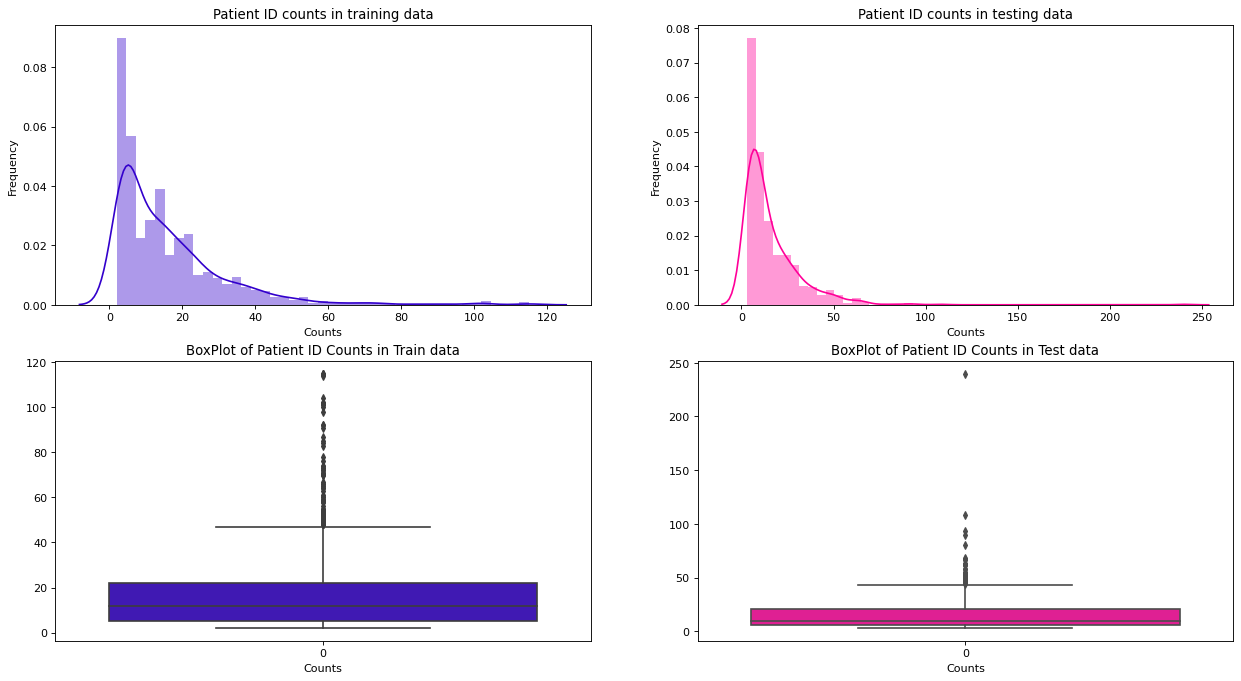

In [17]:
patients_id_counts_train = train_df['patient_id'].value_counts()
patients_id_counts_test = test_df['patient_id'].value_counts()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(19,10), dpi=80, sharex=False, sharey=False)
sns.distplot(patients_id_counts_train, ax=ax[0,0], color='#3300CC', kde=True)
ax[0,0].set_xlabel("Counts")
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Patient ID counts in training data')

sns.distplot(patients_id_counts_test, ax=ax[0,1], color='#FF0099', kde=True)
ax[0,1].set_xlabel("Counts")
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Patient ID counts in testing data')

sns.boxplot(patients_id_counts_train, ax=ax[1,0], color='#3300CC')
ax[1,0].set_xlabel('Counts')
ax[1,0].set_title('BoxPlot of Patient ID Counts in Train data')
sns.boxplot(patients_id_counts_test, ax=ax[1,1], color='#FF0099')
ax[1,1].set_xlabel('Counts')
ax[1,1].set_title('BoxPlot of Patient ID Counts in Test data');

## Gender

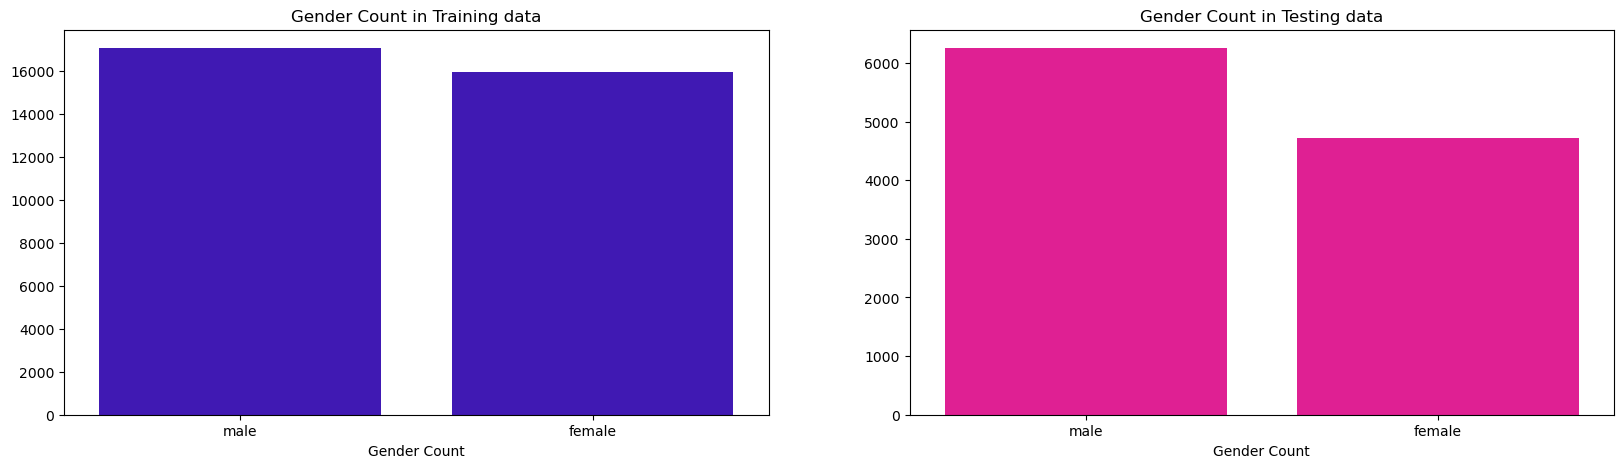

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,5))
sns.countplot(x=train_df['sex'], color='#3300CC', ax=ax[0])
ax[0].set_ylabel("")
ax[0].set_xlabel('Gender Count')
ax[0].set_title("Gender Count in Training data")

sns.countplot(x=test_df['sex'], color="#FF0099", ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel('Gender Count')
ax[1].set_title("Gender Count in Testing data");

## Age

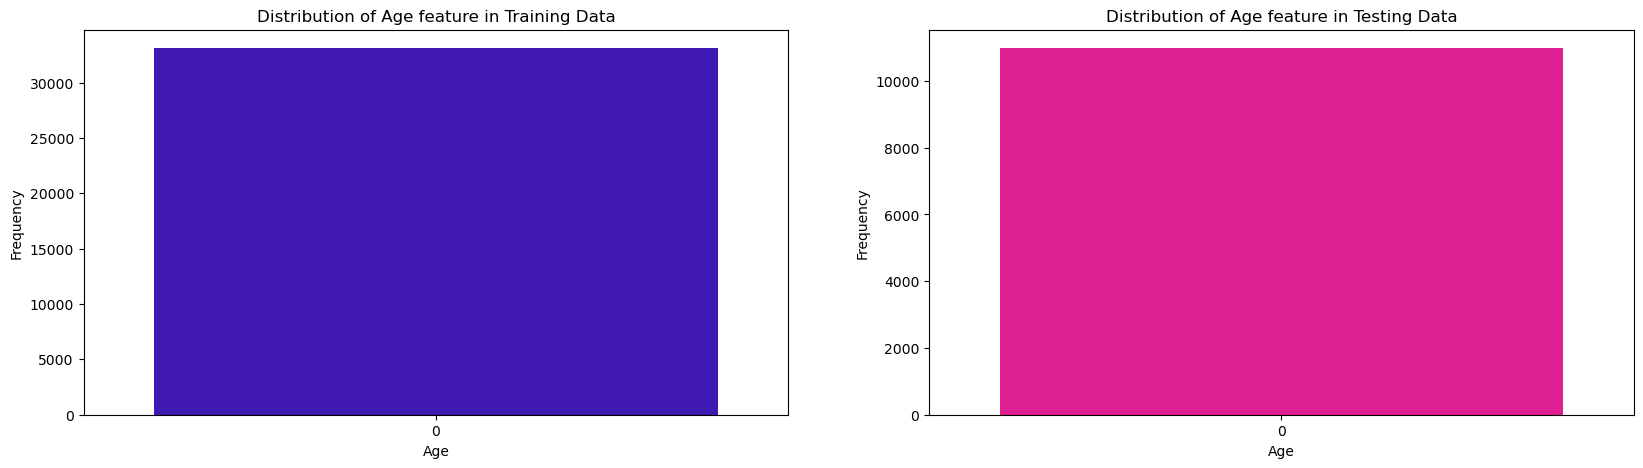

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False , sharey=False, figsize=(20,5))
sns.countplot(train_df['age_approx'], color='#3300CC', ax=ax[0])
ax[0].set_title("Distribution of Age feature in Training Data")
ax[0].set_xlabel("Age")
ax[0].set_ylabel('Frequency')

sns.countplot(test_df['age_approx'], color='#FF0099', ax=ax[1])
ax[1].set_title("Distribution of Age feature in Testing Data")
ax[1].set_xlabel("Age")
ax[1].set_ylabel('Frequency');

In [20]:
age_dist_train_test = pd.concat(
    [train_df['age_approx'].describe(percentiles=[0.01, 0.05, 0.10, 0.15, 0.25, 0.50, 0.75 ,0.90, 0.91, 0.92,0.93, 
                                                        0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
    test_df['age_approx'].describe(percentiles=[0.01, 0.05, 0.10, 0.15, 0.25, 0.50, 0.75 ,0.90, 0.91, 0.92,0.93,
                                                        0.94, 0.95, 0.96, 0.97, 0.98, 0.99])
    ], axis=1)
age_dist_train_test.columns = ['Train_Age', 'Test_Age']
age_dist_train_test.T

,count,mean,std,min,1%,5%,10%,15%,25%,50%,...,91%,92%,93%,94%,95%,96%,97%,98%,99%,max
Train_Age,33058.0,48.870016,14.380360,0.0,20.0,25.0,30.0,35.0,40.0,50.0,...,70.0,70.0,70.0,70.0,70.0,75.0,75.0,75.0,80.0,90.0
Test_Age,10982.0,49.525587,14.370589,10.0,20.0,30.0,30.0,35.0,40.0,50.0,...,70.0,70.0,70.0,70.0,75.0,75.0,80.0,80.0,85.0,90.0


## anatom_site_general_challenge

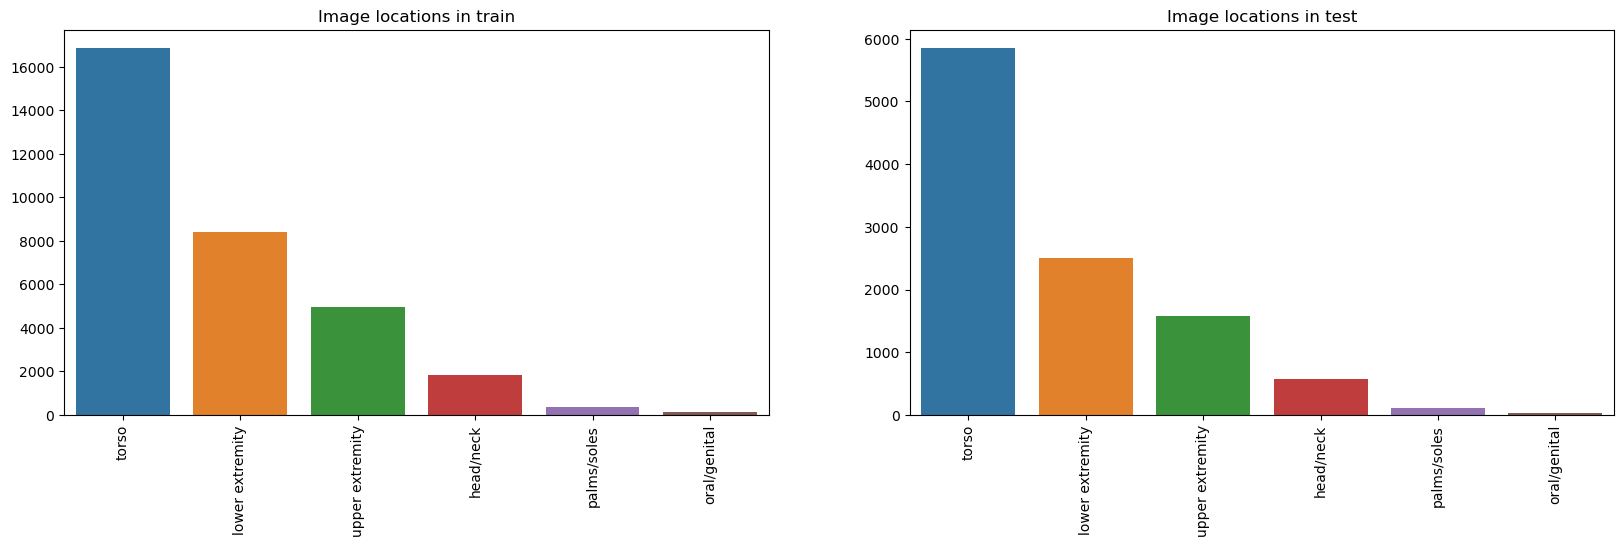

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False , sharey=False, figsize=(20,5))

train_anatom_site_general = train_df["anatom_site_general_challenge"].value_counts().sort_values(ascending=False)
test_anatom_site_general = test_df.anatom_site_general_challenge.value_counts().sort_values(ascending=False)

sns.barplot(x=train_anatom_site_general.index.values, y=train_anatom_site_general.values, ax=ax[0]);
ax[0].set_xlabel("");
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Image locations in train");

sns.barplot(x=test_anatom_site_general.index.values, y=test_anatom_site_general.values, ax=ax[1]);
ax[1].set_xlabel("");
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_title("Image locations in test");

## Target

In [23]:
train_df['target'].value_counts(normalize=True, dropna=False) * 100

0    98.237034
1     1.762966
Name: target, dtype: float64

## Sex Vs. Target & anatom_site_general_challenge Vs. Target

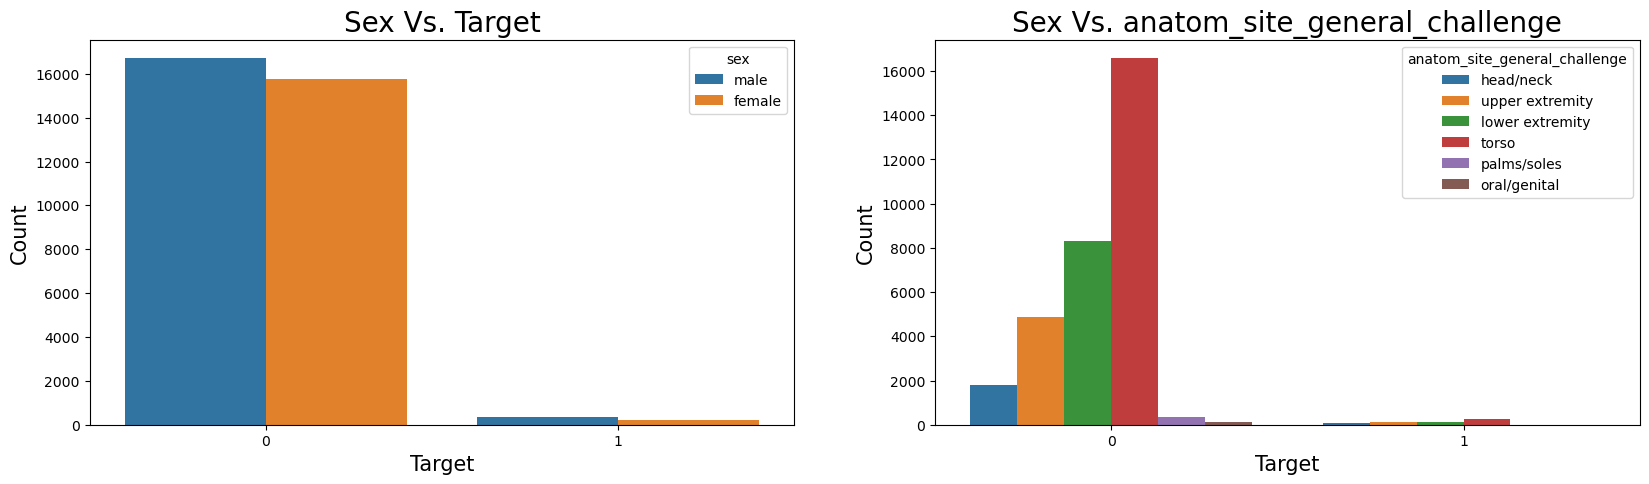

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,5))
sns.countplot(x='target', hue='sex',data=train_df, ax=ax[0])
ax[0].set_xlabel("Target", fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].set_title("Sex Vs. Target", fontsize=20)

sns.countplot(x='target', hue='anatom_site_general_challenge',data=train_df, ax=ax[1])
ax[1].set_xlabel("Target", fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].set_title("Sex Vs. anatom_site_general_challenge", fontsize=20);

## Age Vs. Target

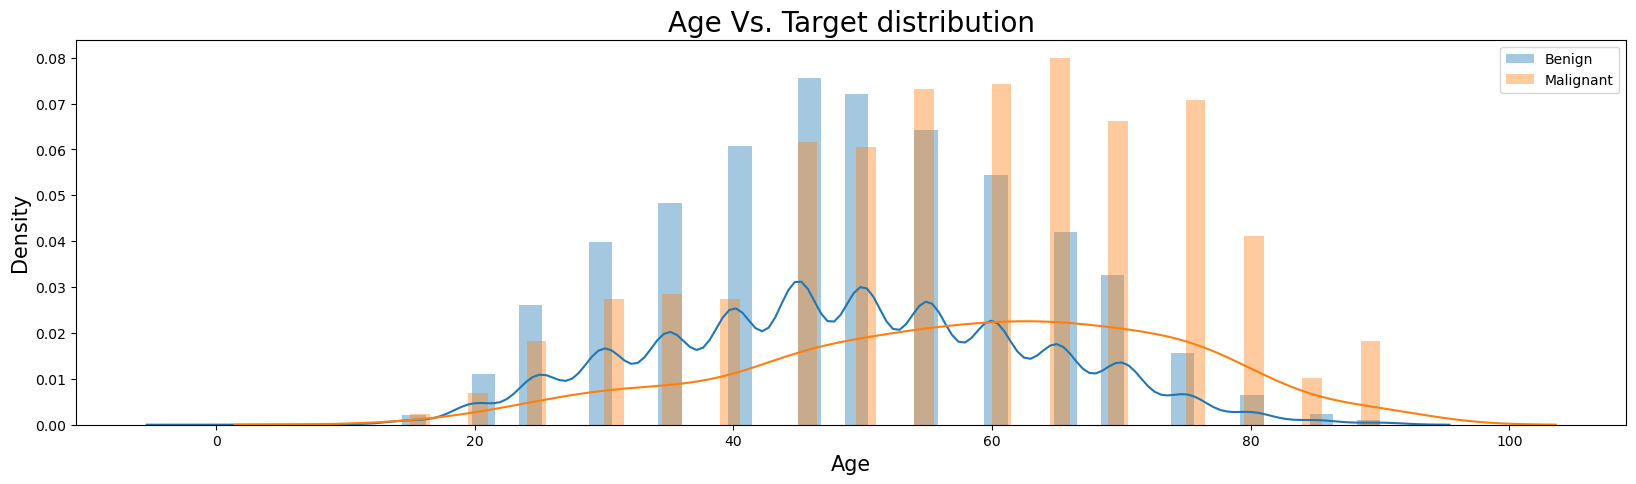

In [25]:
plt.figure(figsize=(20,5))
sns.distplot(train_df.loc[train_df['target'] == 0]['age_approx'], bins=50, label='Benign')
sns.distplot(train_df.loc[train_df['target'] == 1]['age_approx'], bins=50, label='Malignant')
plt.legend(loc='best')
plt.ylabel('Density', fontsize=15)
plt.xlabel('Age', fontsize=15)
plt.title("Age Vs. Target distribution", fontsize=20);

## Training our model with No Tabular features
- For now, we will run/train the model on a single fold only.

In [26]:
from Scripts.train_model import run_model
run_model(fold=0, train_df=train_df)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.071890).  Saving model ...


 20%|██        | 1/5 [57:05<3:48:23, 3425.86s/it]

Epoch : 1 | train_loss : 0.0986 | valid_loss : 0.0719 | valid_auc : 0.8579 
Validation loss decreased (0.071890 --> 0.067238).  Saving model ...


 40%|████      | 2/5 [1:51:06<2:45:49, 3316.66s/it]

Epoch : 2 | train_loss : 0.0749 | valid_loss : 0.0672 | valid_auc : 0.8902 


 60%|██████    | 3/5 [2:45:18<1:49:34, 3287.46s/it]

EarlyStopping counter: 1 out of 2
Epoch : 3 | train_loss : 0.0708 | valid_loss : 0.0709 | valid_auc : 0.8746 
Validation loss decreased (0.067238 --> 0.065598).  Saving model ...


 80%|████████  | 4/5 [3:39:10<54:25, 3265.50s/it]  

Epoch : 4 | train_loss : 0.0706 | valid_loss : 0.0656 | valid_auc : 0.8971 
EarlyStopping counter: 1 out of 2


100%|██████████| 5/5 [4:32:49<00:00, 3273.97s/it]

Epoch : 5 | train_loss : 0.0683 | valid_loss : 0.0673 | valid_auc : 0.9015 
Total training time: 16369.841 seconds


## Generating submission file on the test dataset

In [27]:
from Scripts.predict_on_test import predict_on_test_and_generate_submission_file

model_path = "../working/Models/efficientnet_b5_checkpoint_fold_0.pt"
predict_on_test_and_generate_submission_file(test_df=test_df,
                                            use_tabular_features=False,
                                            model_path=model_path)

Loaded pretrained weights for efficientnet-b5


## Building Gradio demo
Now that we have finalized the model we'll be deploying, we will use this EfficientNet-B5 model to predict on new images.

For this project I will be using [Gradio](https://gradio.app/) library (product of HuggingFace). 

Why Gradio?
The homepage of Gradio descibes it as:
> Gradio is the fastest way to build/demo your machine learning model with a friendly web interface so that anyone can use it, anywhere.

### Gradio Overview

In general, we can have any combination of inputs like
- Images
- Tabular data
- Text
- Numbers
- Video
- Audio
- etc.

In our case we have images and inputs and the output is returned as a probability of whether a patient is sufferig from melanoma skin cancer disease.

Gradio provides an interface that maps from the input(s) to output(s).

    gr.Interface(function, inputs, outputs)
    
Where, `fn` is a python function to map inputs to outputs

Gradio provides a very helpful `Interface` class to create an `inputs -> model/function -> outputs` workflow where the inputs and outputs could be almost anything we want.

In [28]:
## Installing Gradio and importing it. 
try:
    import gradio as gr
except:
    !pip install -q gradio
    import gradio as gr
print(f"Gradio version : {gr.__version__}")

Gradio version : 3.27.0


## Creating a model instance and putting it on the CPU

First, let's make sure our EfficientNetB5 model on CPU

In [29]:
import torch
import numpy as np
import albumentations as A
from Scripts.model import Model

efficientnet_b5_model = Model()
efficientnet_b5_model = torch.nn.DataParallel(efficientnet_b5_model) ## Must wrap our model in nn.DataParallel()
    ## if used multi-gpu's to train the model otherwise we would get state_dict keys mismatch error.
efficientnet_b5_model.load_state_dict(
    torch.load(
        f='efficientnet_b5_checkpoint_fold_0.pt',
        map_location=torch.device("cpu")
    )
)
next(iter(model.parameters())).device

Loaded pretrained weights for efficientnet-b5


device(type='cpu')

## Creating a function to predict on a single images
We create a function that takes an input: image -> transform -> predict with EfficientNetB5 -> output: probability.

This will be our `fn` parameter for our Gradio Interface.

In [30]:
## predict on a single image
def predict_on_single_image(img):
    """
    Function takes an image, transforms for 
    model training like normalizing the statistics
    of the image. Converting the numpy array into
    torch tensor and passing through the model
    to get the prediction probability of a patient
    having melanoma. 
    """
    img = np.array(img)
    transforms = A.Compose([A.Resize(512,512),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225), 
                    max_pixel_value=255.0, 
                    always_apply=True
        )]
    )
    img = transforms(image=img)['image']
    image = np.transpose(img, (2, 0, 1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float).unsqueeze(dim=0)
    model.eval()
    with torch.inference_mode():
        probs = torch.sigmoid(model(image))
        prob_of_melanoma = probs[0].item()
        prob_of_not_having_melanoma = 1 - prob_of_melanoma
        pred_label = {"Probability of Having Melanoma": prob_of_melanoma, 
                      "Probability of Not having Melanoma": prob_of_not_having_melanoma} 
        return pred_label

Let's see our function by performing a prediction of an image from the training dataset.

We'll get some images from training dataset and extract the images paths list. Then we'll open an image with `Image.open()`.

Finally, we pass the image to `predict_on_single_image()`.

In [44]:
import torch
import pathlib
import numpy as np
from PIL import Image

## Taking some images out
images = train_df.iloc[1:10,]
images_paths_list = images['image_path'].tolist()

## Opening an Image
img = Image.open(images_paths_list[8])

## Predicting on the image using the function
predict_on_single_image(img)

{'Probability of Having Melanoma': 0.5395416617393494,
 'Probability of Not having Melanoma': 0.46045833826065063}

### Creating a list of example images
Before we create a demo, we first create a list of examples.

Gradio's `Interface` class takes a list of `examples` parameter is a list of lists.

So, we create a list of lists containing the filepaths of images.

Our gradio demo will showcase these as example inputs to our demo so people can try. 

In [32]:
example_list = [[str(file_path)] for file_path in images_paths_list]
example_list

[['../input/jpeg-melanoma-512x512/train/ISIC_0015719.jpg'],
 ['../input/jpeg-melanoma-512x512/train/ISIC_0052212.jpg'],
 ['../input/jpeg-melanoma-512x512/train/ISIC_0068279.jpg']]

### Building a Gradio interface
Putting everything together ->

Gradio Interface Workflow:
    input: image -> transform -> predict with EfficientNetB5 model -> probability: output

We can do with the `Gr.Interface()` class with the following parameters:
- fn: a python function that maps from inputs to outputs, in our case `the predict_on_single_image()` function.
- inputs: the input to our Interface, such as image using [gradio.Image()](https://gradio.app/docs/#image).
- outputs: the output of the Interface once the inputs are processed with the `fn`, such as a Number [gradio.Number()](https://gradio.app/docs/#number) (for our case probability).
- examples: a list of examples to showcase for the demo.
- title: a string title of the demo.
- description: a string description of the demo.

Once, we've created a demo instance of `gr.Interface()`, we use `demo.launch()` command.

In [33]:
import gradio as gr

## Creating the title and description strings  
title = "Melanoma Cancer Detection App"
description = 'An efficientnet-b5 model that predicts the probability of a patient having melanoma skin cancer or not.'

## Create the Gradio demo
demo = gr.Interface(fn=predict_on_single_image,
                   inputs=gr.Image(type='pil'),
                   outputs=[gr.Label(label='Probabilities')],
                   examples=example_list, title=title,
                   description=description)

## Launch the demo!
demo.launch(debug=False, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://e228186381e2781228.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/uvicorn/protocols/http/httptools_impl.py", line 420, in run_asgi
    self.scope, self.receive, self.send
  File "/opt/conda/lib/python3.7/site-packages/uvicorn/middleware/proxy_headers.py", line 78, in __call__
    return await self.app(scope, receive, send)
  File "/opt/conda/lib/python3.7/site-packages/fastapi/applications.py", line 270, in __call__
    await super().__call__(scope, receive, send)
  File "/opt/conda/lib/python3.7/site-packages/starlette/applications.py", line 124, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/opt/conda/lib/python3.7/site-packages/starlette/middleware/errors.py", line 184, in __call__
    raise exc
  File "/opt/conda/lib/python3.7/site-packages/starlette/middleware/errors.py", line 162, in __call__
    await self.app(scope, receive, _send)
  File "/opt/conda/lib/python3.7/site-packages/starlette/middlew

Woow!!!

Our application is up and running, this link is only temporary and and it remains ony for 72 hours. For permanent hosting,
we can upload our Gradio app Interface to [HuggingFace Spaces](https://huggingface.co/spaces). 

Now download all the files and folders from kaggle output manually & this kaggle kernel locally

## Turning our Melanoma skin cancer detection Gradio Demo into a deployable app

We'll deploy the demo application on HuggingFace Spaces.

What is HuggingFace Spaces?

It is a resource that allows anybody to host and share machine learning application.

### Deployed Gradio App Structure
To upload our gradio app, we'll want to put everything together into a singe directory.

For example, our demo might live at the path `demos/melanoma_skin_cancer_files` with the following structure:
```    
demos/
    └── melanoma_skin_cancer_files/
        ├── efficientnet_b5_checkpoint_fold_0.pt
        ├── app.py
        ├── examples/
        │   ├── image_1.jpg
        │   ├── image_2.jpg
        │   └── image_3.jpg
        ├── model.py
        └── requirements.txt
```

Where:
- `efficientnet_b5_checkpoint_fold_0` is our trained model.
- `app.py` contains our Gradio app.
    **Note**: `app.py` is the default filename used for HuggingFace Spaces, if we deploy our apps there.
- `examples` contains sample images to showcase the demo of our Gradio application.
- `model.py` contains the main model/transformations code associated with our model.
- `requirements.txt` file contains the dependencies/packages to run our application such as torch, albumentations, torchvision, gradio, numpy.

### Creating a demo folder to store our Melanoma skin cancer App files
To begin, we'll create an empty directory `demos/` that will contain all our necessary files for the application.

We can achive this using Python's `pathlib.Path("path_of_dir")` to establish directory path and then `pathlib.Path("path_of_dir").mkdir()` to create it.

In [1]:
############### ROOT_DIR : I Have put the files in my E: drive
## Importing Packages 
import shutil
from pathlib import Path
import os

ROOT_DIR = "\\".join(os.getcwd().split("\\")[:2])

## Create Melanoma skin cancer demo path
melanoma_app_demo_path = Path(f"{ROOT_DIR}/demos/melanoma_skin_cancer_files")

## Removing files that might already exist and creating a new directory.
if melanoma_app_demo_path.exists():
    shutil.rmtree(melanoma_app_demo_path)
    melanoma_app_demo_path.mkdir(parents=True, # Do we want to make parent folders?
                                exist_ok=True) # Create even if they already exists? 
else:
    ## If the path doesn't exist, create one 
    melanoma_app_demo_path.mkdir(parents=True,
                                exist_ok=True)

### Creating a folder of example images to use with our Melanoma skin cancer demo
Now we'll create an empty directory called `examples` and store some images (namely - ISIC_0015719.jpg, ISIC_0052212.jpg, ISIC_0068279.jpg) from the training dataset provided in the competition (which we download manually) from the [here](https://www.kaggle.com/datasets/cdeotte/jpeg-melanoma-512x512). Download the 1ts three images from the training dataset mentioned above.

Put these images in the Data/Input (whatever you want to call) folder.

To do so we'll:

1. Create an empty directory `examples/` within the `demos/melanoma_skin_cancer_files` directory.
2. Download the top 3 mentioned images from the training dataset from the link above.
3. Collect the filepaths into a list.
4. Copy these 3 images from the train dataset to the `demos/melanom_skin_cancer_files/examples/` directory.

In [2]:
import shutil
from pathlib import Path

## Create examples directory
melanoma_app_examples_path = melanoma_app_demo_path / "examples"
melanoma_app_examples_path.mkdir(parents=True, exist_ok=True)

## collecting the image paths of 4 images 
melanoma_app_examples = [Path(f"{ROOT_DIR}/input/jpeg-melanoma-512x512/train/ISIC_0015719.jpg"),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/train/ISIC_0052212.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/train/ISIC_0068279.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/train/ISIC_0149568.jpg')]
for example in melanoma_app_examples:
    destination = melanoma_app_examples_path / example.name
    shutil.copy(src=example, dst=destination)

In [10]:
## collecting the image paths of some more images but this time from the testing folder 
melanoma_app_examples = [Path(f"{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0052060.jpg"),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0082004.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0082785.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0105104.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0112420.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0155983.jpg'),
                        Path(f'{ROOT_DIR}/input/jpeg-melanoma-512x512/test/ISIC_0171865.jpg')]
for example in melanoma_app_examples:
    destination = melanoma_app_examples_path / example.name
    shutil.copy(src=example, dst=destination)

Now we verify our example images are present, let's list the contents of our `demo/melanoma_skin_cancer/examples/` directory with `os.listdir()` and then format the filepaths into a list of lists (to make it compatible with the Gradio's `gradio.Interface()`, example parameter).

In [11]:
example_list = [["examples/" + example] for example in os.listdir(melanoma_app_examples_path)]
example_list

[['examples/ISIC_0015719.jpg'],
 ['examples/ISIC_0052060.jpg'],
 ['examples/ISIC_0052212.jpg'],
 ['examples/ISIC_0068279.jpg'],
 ['examples/ISIC_0082004.jpg'],
 ['examples/ISIC_0082785.jpg'],
 ['examples/ISIC_0105104.jpg'],
 ['examples/ISIC_0112420.jpg'],
 ['examples/ISIC_0149568.jpg'],
 ['examples/ISIC_0155983.jpg'],
 ['examples/ISIC_0171865.jpg']]

### Moving our trained EfficientNet-B5 model into our Melanoma demo directory.
We previously saved our model binary file into the `Models` directory while training as `Models/efficientnet_b5_checkpoint_fold_0.pt`.

We use Python's `shutil.move()` method and passing in `src`(the source path of the target file) and `dst` (the destination folder path of the target file to be moved into) parameters.

In [4]:
## Importing Libraries
import shutil

## Create a source path for our target model
efficientnet_b5_model_path = f"{ROOT_DIR}\\output\\working\\Models\\efficientnet_b5_checkpoint_fold_0.pt"

## Create a destination path for our target model
efficientnet_b5_model_destination = melanoma_app_demo_path / efficientnet_b5_model_path.split("\\")[-1]

## Try to move the file
try:
    print(f"Attempting to move the {efficientnet_b5_model_path} to {efficientnet_b5_model_destination}")
    
    ## Move the model
    shutil.move(src=efficientnet_b5_model_path,
               dst=efficientnet_b5_model_destination)
    
    print("Model move completed")
## If the model has already been moved, check if it exists
except:
    print(f"No model found at {efficientnet_b5_model_path}, perhaps it's already moved.")
    print(f"Model already exists at {efficientnet_b5_model_destination}: {efficientnet_b5_model_destination.exists()}")

Attempting to move the E:\Melanoma_skin_cancer_detection\output\working\Models\efficientnet_b5_checkpoint_fold_0.pt to E:\Melanoma_skin_cancer_detection\demos\melanoma_skin_cancer_files\efficientnet_b5_checkpoint_fold_0.pt
Model move completed


### Turning our EfficientNet-B5 model into a Python script (`model.py`)
Our current model's `state_dict()` is saved to `demos/melanoma_skin_cancer/efficientnet_b5_checkpoint_fold_0.pt`.

To load it it we can use `model.load_state_dict()` with `torch.load()`. But before that we need to instantiate a model.

To do this in a modular fashion we'll create a script model.py which contains the model definition into a function called `Model()`.

In [5]:
## Now if we look into which directory we are currently, we'll find that using the following code
os.getcwd()

'E:\\Melanoma_skin_cancer_detection\\notebooks'

Now we will move into the demos directory where we will write some helper utilities.

In `cd ../demos/`: `..` means we are moving outside of the notebooks directory.
`demos/`: means we moving inside the demos directory.

In [6]:
cd ../demos/

E:\Melanoma_skin_cancer_detection\demos


In [7]:
%%writefile melanoma_skin_cancer_files/model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet


class Model(nn.Module):
    """
    Creates an efficientnet-b5 model instance.    
    """
    def __init__(self, model_name="efficientnet-b5", pool_type=F.adaptive_avg_pool2d):
        super().__init__()
        self.pool_type = pool_type
        self.model_name = model_name
        self.backbone = EfficientNet.from_pretrained(model_name)
        in_features = getattr(self.backbone, "_fc").in_features
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        features = self.pool_type(self.backbone.extract_features(x), 1)
        features = features.view(x.size(0), -1)
        return self.classifier(features)

Writing melanoma_skin_cancer_files/model.py


### Turning our Melanoma Skin Cancer Gradio App into a Python Script (`app.py`)


In [8]:
%%writefile melanoma_skin_cancer_files/app.py
## Importing Libraries
import os
import torch
import numpy as np
import gradio as gr
from model import Model
import albumentations as A

## Creating a model instance
efficientnet_b5_model =  Model()
efficientnet_b5_model = torch.nn.DataParallel(efficientnet_b5_model) ## Must wrap our model in nn.DataParallel()
    ## if used multi-gpu's to train the model otherwise we would get state_dict keys mismatch error.
efficientnet_b5_model.load_state_dict(
    torch.load(
        f='efficientnet_b5_checkpoint_fold_0.pt',
        map_location=torch.device("cpu")
    )
)

## Predict on a single image
def predict_on_single_image(img):
    """
    Function takes an image, transforms for 
    model training like normalizing the statistics
    of the image. Converting the numpy array into
    torch tensor and passing through the model
    to get the prediction probability of a patient
    having melanoma. 
    """
    img = np.array(img)
    transforms = A.Compose([A.Resize(512,512),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225), 
                    max_pixel_value=255.0, 
                    always_apply=True
        )]
    )
    img = transforms(image=img)['image']
    image = np.transpose(img, (2, 0, 1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float).unsqueeze(dim=0)
    efficientnet_b5_model.eval()
    with torch.inference_mode():
        probs = torch.sigmoid(efficientnet_b5_model(image))
        prob_of_melanoma = probs[0].item()
        prob_of_not_having_melanoma = 1 - prob_of_melanoma
        pred_label = {"Probability of Having Melanoma": prob_of_melanoma, 
                      "Probability of Not having Melanoma": prob_of_not_having_melanoma} 
        return pred_label
    
## Gradio App
import gradio as gr

## Examples directory path
melanoma_app_examples_path = "examples"

## Creating the title and description strings  
title = "Melanoma Cancer Detection App"
description = 'An efficientnet-b5 model that predicts the probability of a patient having melanoma skin cancer or not.'
example_list = [["examples/" + example] for example in os.listdir(melanoma_app_examples_path)]

## Create the Gradio demo
demo = gr.Interface(fn=predict_on_single_image,
                   inputs=gr.Image(type='pil'),
                   outputs=[gr.Label(label='Probabilities')],
                   examples=example_list, title=title,
                   description=description)

## Launch the demo!
demo.launch(debug=False, share=True)

Writing melanoma_skin_cancer_files/app.py


### Creating a requirements.txt file for our Gradio App(`requirements.txt`)
This is the last file we need to create for our application.

This file contains all the necessary packages for our Gradio application.

When we deploy our demo app to HuggingFace Spaces, it will search through this file and install the dependencies we mention so our appication can run.

1. `torch==1.13.0`
2. `torchvision==0.14.0`
3. `albumentations==1.2.1`
4. `efficientnet_pytorch==0.7.1`
5. `Pillow==8.4.0`
6. `numpy==1.22.4`
7. `gradio==3.1.4`

In [9]:
%%writefile melanoma_skin_cancer_files/requirements.txt
torch==1.13.0
torchvision==0.14.0
albumentations==1.2.1
efficientnet_pytorch==0.7.1
Pillow==8.4.0
numpy==1.22.4
gradio==3.1.4

Writing melanoma_skin_cancer_files/requirements.txt


## Deploying our Application to HuggingFace Spaces
To deploy our demo, there are 2 main options for uploading to HuggingFace Spaces

1. [Uploading via the Hugging Face Web Interface (easiest)](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui)
2. [Uploading via the command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal)

NOTE: To host any application on HuggingFace, we first need to [sign up for a free HuggingFace Account](https://huggingface.co/join)

### Running our Application locally

1. Open the terminal or command prompt.
2. Changing the `melanoma_skin_cancer_files` directory (cd melanoma_skin_cancer_files).
3. Creating an environment `(python3 -m venv env)` or use `(python -m venv env)`.
4. Activating the environment `(source env/Scripts/activate)`.
5. Installing the `requirements.txt` using `pip install -r requirements.txt`.
> If faced any errors, we might need to upgrade `pip` using `pip install --upgrade pip`.  
6. Run the app `(python3 app.py).`

This should results in a Gradio demo locally at the URL such as : `http://127.0.0.1:7860/`. 

### Uploading to Hugging Face
We've verified our Melanoma_skin_cancer detection application is working in our local system.

To upload our application to Hugging Face Spaces, we need to do the following.

1. [Sign up](https://huggingface.co/welcome) for a Hugging Face account.
2. Start a new Hugging Face Space by going to our profile at the top right corner and then select [New Space](https://huggingface.co/new-space).
3. Declare the name to the space like `Chirag1994/melanoma_skin_cancer_detection_app`.
4. Select a license (I am using MIT license).
5. Select Gradio as the Space SDK (software development kit).
6. Choose whether your Space is Public or Private (I am keeping it Public).
7. Click Create Space.
8. Clone the repository locally by running: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in the terminal or command prompt. In our case mine would be like - `git clone https://huggingface.co/spaces/Chirag1994/melanoma_skin_cancer_detection_app`.
9. Copy/Move the contents of the downloaded `melanoma_skin_cancer_detection_app` folder to the cloned repo folder.
10. To upload files and track larger files (e.g., files that are greater than 10MB) for them we need to [install Git LFS](https://git-lfs.github.com/) which stands for Git large File Storage.
11. Open up the cloned directory using VS code (I'm using VS code), and use the terminal (git bash in my case) and after installing the git lfs, use the command `git lfs install` to start tracking the file that we want to track. For example - git lfs track `"efficientnet_b5_checkpoint_fold_0.pt"`.
12. Create a new .gitignore file and the files & folders that we don't want git to track like :
    - `__pycache__/`
    - `.vscode/`
    - `venv/`
    - `.gitignore`
    - `.gitattributes`
13. Add the rest of the files and commit them with:
    - `git add .`
    - `git commit -m "commit message that you want"`
14. Push(load) the files to Hugging Face
    - `git push`
15. It might a couple of minutes to finish and then the app will be up and running. 

## Our Final Application deployed on HuggingFace Spaces 

In [1]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/Chirag1994/Melanoma_Skin_Cancer_Detection_App/+", width=900, height=750)